# Analyze N-Back Data

In [2]:
%matplotlib inline

import os 
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from nltools.data import Brain_Data, Adjacency, Design_Matrix
from nltools.file_reader import onsets_to_dm
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import regress
from nilearn.plotting import plot_img_on_surf, plot_stat_map, plot_glass_brain, view_img_on_surf
import nibabel as nib
import mne
from mne.io import read_raw_snirf
import mne.io.snirf
from snirf import Snirf
import h5py
from kernel.utils import load_snirf_file, get_resource_path, get_optodes, extract_stimulus_data, pick_channels_from_distance_mne_epochs

mne.viz.set_3d_backend("notebook")

base_dir = '/Users/lukechang/Dropbox/Kernel'

Using notebook 3d backend.



## Analyze NIFTI Reconstruction with nltools

To speed up loading data, we save a resampled version of the data. Alternatively, we could load it in the original 4 x 4 x 4 space like we do using nibabel below.

The nifti reconstructed data has been trimmed to 1 sec before start experiment and 1 sec after experiment end.

We are seeing large scaling differences across regions, so z-scoring data for now, but that means we are losing absolute HbO concentrations

Mask is s k=50 whole brain parcellation based on neurosynth coactivations. Target ROIs correspond to left and right somatomotor cortex

/opt/anaconda3/envs/mne/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:280: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/opt/anaconda3/envs/mne/lib/python3.11/site-packages/nilearn/masking.py:980: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


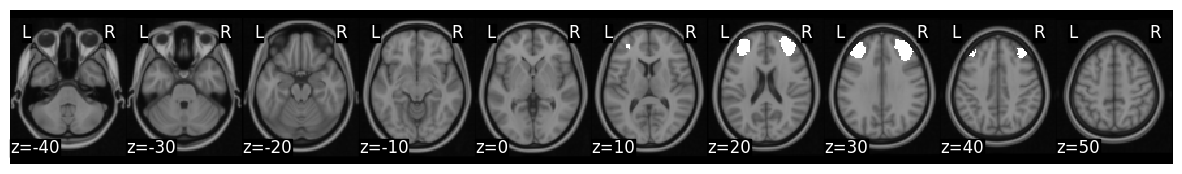

In [4]:
metadata = {'subject':'S003', 'task_name':'NBack', 'task_id':'46ae527'}

# data_nifti = Brain_Data(os.path.join(base_dir, 'Data', metadata["task_name"],  f'Test_{metadata["subject"]}_{metadata["task_id"]}_HbO.nii.gz') )
# data_nifti.write(os.path.join(base_dir, 'Data', metadata["task_name"],  f'Test_{metadata["subject"]}_{metadata["task_id"]}_HbO_resampled.nii.gz'))

data_nifti = Brain_Data(os.path.join(base_dir, 'Data', metadata["task_name"], f'Test_{metadata["subject"]}_{metadata["task_id"]}_HbO_resampled.nii.gz') )
data_nifti = data_nifti.standardize(method='zscore')
toffset =  nib.load(os.path.join(base_dir, 'Data', metadata["task_name"], f'Test_{metadata["subject"]}_{metadata["task_id"]}_HbO.nii.gz')).header['toffset']
n_tr = len(data_nifti)

mask = Brain_Data(os.path.join(get_resource_path(), 'k50_2mm.nii.gz'))
mask_x = expand_mask(mask)

mask_x[44].plot()
plt.show()

### Create Design_Matrix

Extract event information and plot average activity within each ROI

In [11]:
print(events['trial_type'].unique())
print(events['block_type'].unique())

events

[nan 'match' 'no_match' 'initialize']
['rest' 'control' '2-back' '1-back']


timestamp              event    duration  block block_type  trial  \
0     19.307992   start_experiment  488.555000    NaN       rest    NaN   
1     19.308993         start_rest   25.003999    NaN       rest    NaN   
2     44.313992        start_block   52.625000    1.0    control    NaN   
3     44.314993          start_cue    4.997999    1.0    control    NaN   
4     50.224992  start_block_valid   46.714000    1.0    control    NaN   
..          ...                ...         ...    ...        ...    ...   
405  479.421992     start_stimulus    0.756000    6.0     2-back  167.0   
406  481.103992        start_trial    1.758000    6.0     2-back  168.0   
407  481.104992     start_stimulus    0.756000    6.0     2-back  168.0   
408  481.729392           keypress    0.000000    6.0     2-back  168.0   
409  482.862993         start_rest   24.998999    NaN       rest    NaN   

     stimulus trial_type  response_RT  response_outcome response_pressed  \
0         NaN        NaN          NaN               NaN              NaN   
1         NaN        NaN          NaN               NaN              NaN   
2         NaN        NaN          NaN               NaN              NaN   
3         NaN        NaN          NaN               NaN              NaN   
4         NaN        NaN          NaN               NaN              NaN   
..        ...        ...          ...               ...              ...   
405       8.0   no_match          NaN               NaN              NaN   
406       5.0      match       0.6254               1.0            space   
407       5.0      match       0.6254               1.0            space   
408       5.0      match       0.6254               1.0            space   
409       NaN        NaN          NaN               NaN              NaN   

         all_responses_RT all_responses_outcome all_responses_pressed  \
0                     NaN                   NaN                   NaN   
1                     NaN                   NaN                   NaN   
2                     NaN                   NaN                   NaN   
3                     NaN                   NaN                   NaN   
4                     NaN                   NaN                   NaN   
..                    ...                   ...                   ...   
405                   NaN                   NaN                   NaN   
406  [0.6253999999998996]                   [1]             ['space']   
407  [0.6253999999998996]                   [1]             ['space']   
408  [0.6253999999998996]                   [1]             ['space']   
409                   NaN                   NaN                   NaN   

               outcome  correct  timestamp_adjusted  
0    correct_rejection     True            0.807992  
1    correct_rejection     True            0.808993  
2    correct_rejection     True           25.813992  
3    correct_rejection     True           25.814993  
4    correct_rejection     True           31.724992  
..                 ...      ...                 ...  
405  correct_rejection     True          460.921992  
406                hit     True          462.603992  
407                hit     True          462.604992  
408                hit     True          463.229392  
409  correct_rejection     True          464.362993  

[410 rows x 17 columns]

/var/folders/5b/m183lc3x27n9krrzz85z2x1c0000gn/T/ipykernel_37629/1218208253.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  events['block_type'].fillna('rest', inplace=True)
/opt/anaconda3/envs/mne/lib/python3.11/site-packages/nilearn/masking.py:980: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converte

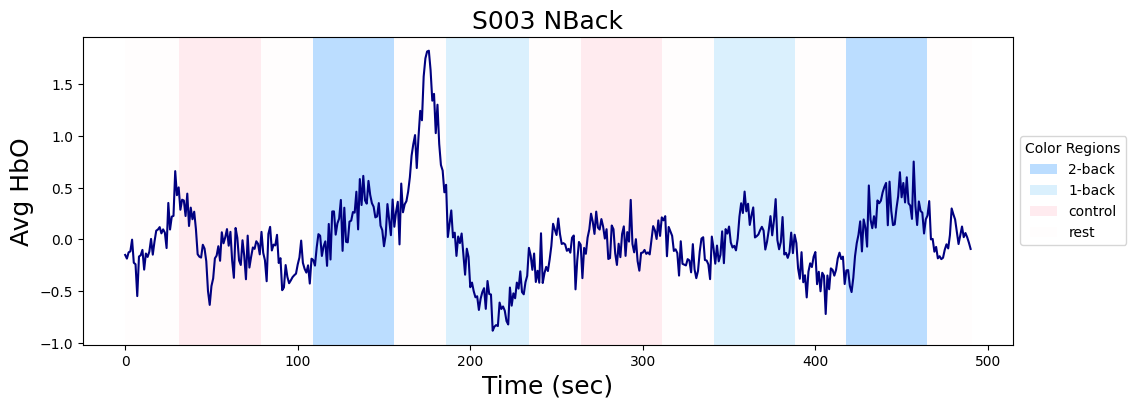

In [14]:
events = pd.read_csv(os.path.join(base_dir, 'Data', metadata['task_name'], f'Test_{metadata["subject"]}_{metadata["task_id"]}_task_events.tsv'), sep='\t')
events['block_type'].fillna('rest', inplace=True)
events['timestamp_adjusted'] = events['timestamp'] - toffset

dm = onsets_to_dm(events.query('event=="start_trial"')[['timestamp_adjusted','duration','block_type']].rename(columns={'timestamp_adjusted':'Onset','duration':'Duration','block_type':'Stim'}), sampling_freq=1.0, run_length=n_tr)

# Generate Plot
f,a = plt.subplots(1, figsize=(12,4))

right_ifg = data_nifti.extract_roi(mask_x[27])
a.plot(right_ifg, color='navy')

# Add colored backgrounds for each integer
colors={'2-back':'dodgerblue', '1-back':'lightskyblue', 'control':'pink', 'rest':'snow'}
for i,row in dm.iterrows():
    if row['2-back'] == 1:
        a.axvspan(i, i+1, facecolor=colors['2-back'], alpha=0.3)
    elif row['1-back'] == 1:
        a.axvspan(i, i+1, facecolor=colors['1-back'], alpha=0.3)
    elif row['control'] == 1:
        a.axvspan(i, i+1, facecolor=colors['control'], alpha=0.3)
    else:
        a.axvspan(i, i+1, facecolor=colors['rest'], alpha=0.3)

a.set_xlabel('Time (sec)', size=18)
a.set_ylabel('Avg HbO', size=18)
legend_elements = [
    Patch(facecolor=colors['2-back'], alpha=0.3, label='2-back'),
    Patch(facecolor=colors['1-back'], alpha=0.3, label='1-back'),
    Patch(facecolor=colors['control'], alpha=0.3, label='control'),
    Patch(facecolor=colors['rest'], alpha=0.3, label='rest')
]
a.legend(handles=legend_elements, title='Color Regions', loc='center left', bbox_to_anchor=(1, 0.5))
a.set_title(f"{metadata['subject']} {metadata['task_name']}", size=18)
plt.savefig(os.path.join(base_dir, 'Figures', metadata['task_name'], f"{metadata['subject']}_{metadata['task_name']}_AverageDLPFCActivity_Experiment.png"), dpi=150)
plt.show()


### Run Regression

#### Run using nltools 2 x 2 x 2 resampling

Plotting unthresholded image
Plotting unthresholded image


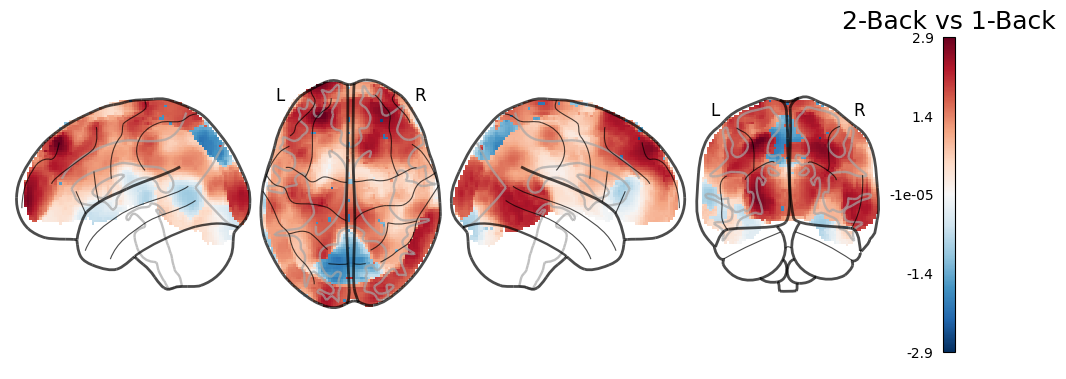

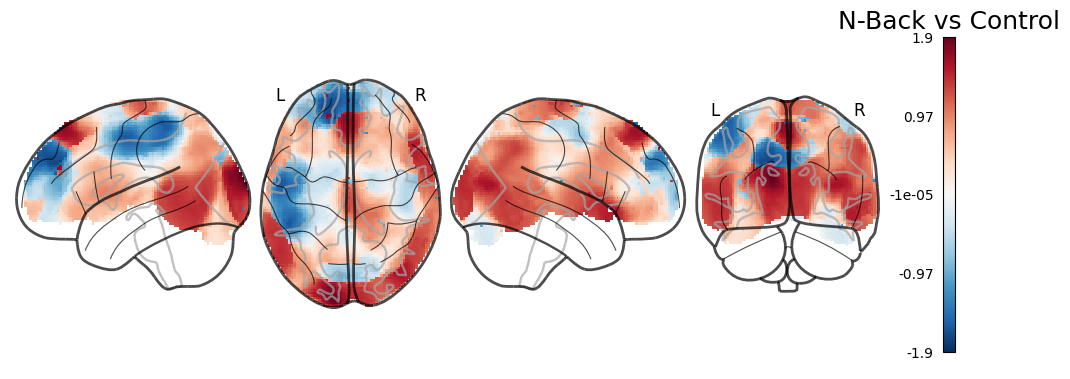

In [27]:
data_nifti.X = dm.convolve().add_dct_basis(duration=100).add_poly(0)
stats_output = data_nifti.regress()

contrast_code = np.zeros(data_nifti.X.shape[1])
contrast_code[data_nifti.X.columns=='2-back_c0'] = 1
contrast_code[data_nifti.X.columns=='1-back_c0'] = -1

n2_v_n1 = stats_output['beta'] * contrast_code
n2_v_n1.write(os.path.join(base_dir, 'Analyses', metadata['task_name'], f"{metadata['subject']}_{metadata['task_name']}_2bV1b_nltools.nii.gz"))
n2_v_n1.plot(view='glass')
plt.title('2-Back vs 1-Back', size=18)
plt.savefig(os.path.join(base_dir, 'Figures', metadata['task_name'], f"{metadata['subject']}_{metadata['task_name']}_2bV1b_nltools.png"), dpi=150)

contrast_code = np.zeros(data_nifti.X.shape[1])
contrast_code[data_nifti.X.columns=='2-back_c0'] = 0.5
contrast_code[data_nifti.X.columns=='1-back_c0'] = 0.5
contrast_code[data_nifti.X.columns=='control_c0'] = -1
nb_v_con = stats_output['beta'] * contrast_code
nb_v_con.plot(view='glass')
plt.title('N-Back vs Control', size=18)
nb_v_con.write(os.path.join(base_dir, 'Analyses', metadata['task_name'], f"{metadata['subject']}_{metadata['task_name']}_nbackVcontrol_nltools.nii.gz"))

plt.show()


#### Run using nibabel 4 x 4 x 4 original sampling

/var/folders/5b/m183lc3x27n9krrzz85z2x1c0000gn/T/ipykernel_37629/783642658.py:9: RuntimeWarning: invalid value encountered in divide
  flattened_dat = ((flattened_dat.T - np.nanmean(flattened_dat, axis=1))/ np.nanstd(flattened_dat, axis=1)).T # z-score


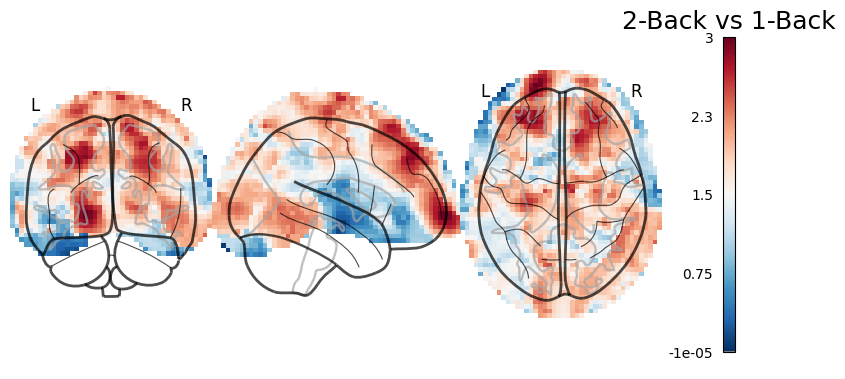

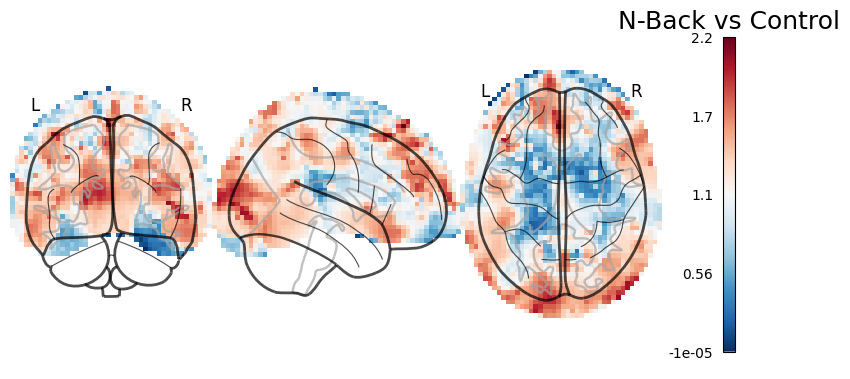

In [40]:
# Load Data using Nibabel
data_nib =  nib.load(os.path.join(base_dir, 'Data', metadata['task_name'],  f'Test_{metadata["subject"]}_{metadata["task_id"]}_HbO.nii.gz') )
dat_nib = data_nib.get_fdata()
# dat_nib[data_nib==0] = np.nan

# Run vectorized regression at each voxel
dm_nib = dm.convolve().add_dct_basis(duration=100).add_poly(0)
flattened_dat = dat_nib.reshape(-1, dat_nib.shape[-1])
flattened_dat = ((flattened_dat.T - np.nanmean(flattened_dat, axis=1))/ np.nanstd(flattened_dat, axis=1)).T # z-score
b, se, t, p, df, res = regress(dm_nib, flattened_dat.T)

contrast_code = np.zeros(dm_nib.shape[1])
contrast_code[dm_nib.columns=='2-back_c0'] = 1
contrast_code[dm_nib.columns=='1-back_c0'] = -1
n2_v_n1 = np.dot(b.T, contrast_code)
n2_v_n1 = nib.Nifti1Image(np.nan_to_num(n2_v_n1, nan=0.0).reshape(dat_nib.shape[:-1]), affine=data_nib.affine)
nib.save(n2_v_n1, os.path.join(base_dir, 'Analyses', metadata['task_name'], f"{metadata['subject']}_{metadata['task_name']}_2bV1b_nibabel.nii.gz"))
plot_glass_brain(n2_v_n1, cmap='RdBu_r', colorbar=True, plot_abs=True)
plt.title('2-Back vs 1-Back', size=18)
plt.savefig(os.path.join(base_dir, 'Figures', metadata['task_name'], f"{metadata['subject']}_{metadata['task_name']}_2bV1b_nibabel.png"), dpi=150)

contrast_code = np.zeros(dm_nib.shape[1])
contrast_code[dm_nib.columns=='2-back_c0'] = .5
contrast_code[dm_nib.columns=='1-back_c0'] = .5
contrast_code[dm_nib.columns=='control_c0'] = -1
nb_v_con = np.dot(b.T, contrast_code)
nb_v_con = nib.Nifti1Image(np.nan_to_num(nb_v_con, nan=0.0).reshape(dat_nib.shape[:-1]), affine=data_nib.affine)
nib.save(n2_v_n1, os.path.join(base_dir, 'Analyses', metadata['task_name'], f"{metadata['subject']}_{metadata['task_name']}_nbackVcontrol_nibabel.nii.gz"))
plot_glass_brain(nb_v_con, cmap='RdBu_r', colorbar=True, plot_abs=True)
plt.title('N-Back vs Control', size=18)
plt.savefig(os.path.join(base_dir, 'Figures', metadata['task_name'], f"{metadata['subject']}_{metadata['task_name']}_2bV1b_nibabel.png"), dpi=150)

plt.show()

view_img_on_surf(n2_v_n1, bg_on_data=True, symmetric_cmap=True)
# view_img_on_surf(nb_v_con, bg_on_data=True, symmetric_cmap=True)


### Create Peristimulus Plot

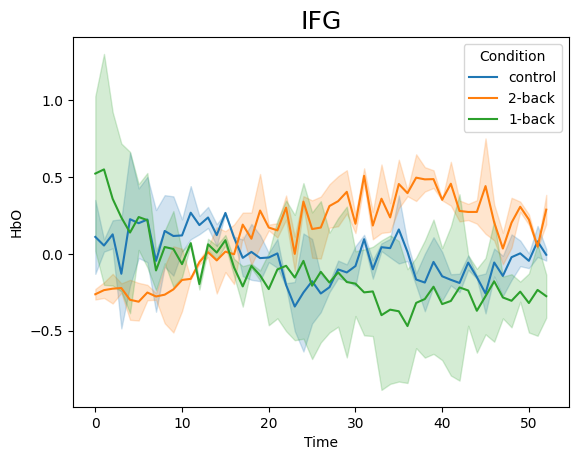

In [39]:
events['block_id'] = events['block_type'] + '_' + events['block'].fillna(0).astype(int).astype(str)
dm_block = onsets_to_dm(events.query('block_type != "rest"')[['timestamp_adjusted','duration','block_id']].rename(columns={'timestamp_adjusted':'Onset','duration':'Duration','block_id':'Stim'}), sampling_freq=1.0, run_length=len(data_nifti))

blocks = {}
for c in dm_block:
    blocks[c] = right_ifg[dm_block[c]==1]
shortest_block = np.min([blocks[x].shape for x in blocks])
blocks = pd.DataFrame({x:blocks[x][:shortest_block] for x in blocks})
blocks['Time'] = blocks.index
blocks = blocks.melt(id_vars=['Time'], var_name='Block', value_name='HbO')
blocks['Condition'] = [x[:-2] for x in blocks['Block']]

# f,a = plt.subplots(ncols=1, figsize=(6,5), sharey=True, sharex=True)
sns.lineplot(data=blocks, x='Time', y='HbO', hue='Condition')
plt.title('IFG', size=18)
plt.savefig(os.path.join(base_dir, 'Figures', metadata['task_name'], f"{metadata['subject']}_{metadata['task_name']}_AverageDLPFCActivity_Block.png"), dpi=150)
blocks.to_csv(os.path.join(base_dir, 'Analyses', metadata['task_name'], f"{metadata['subject']}_{metadata['task_name']}_DLPFC_Block.csv"), index=False)

plt.show()

## Analyze HB Moments SNIRF
We will be using functions from MNE to load and analyze the SNIRF data. 

Unfortunately, there are a few issues with using MNE. 
1) MNE has not approved a PR to load correct details from Moments or Gates https://github.com/mne-tools/mne-python/pull/9661
2) MNE does not properly scale the data (raw._data *= 1e-6)
3) MNE does not properly load data about stimulus events. Currently need to manually access the HDF5 containers

In [42]:
metadata = {'subject':'S003', 'task_name':'NBack', 'task_id':'46ae527'}

# Load data
snirf_file = os.path.join(base_dir, 'Data', metadata["task_name"],  f'Test_{metadata["subject"]}_{metadata["task_id"]}_5.snirf')
raw = load_snirf_file(snirf_file)

# Get information about each optode
probe_data = get_optodes(snirf_file) 

# Apply filter
raw = raw.filter(0.01, 0.1, h_trans_bandwidth=0.01, l_trans_bandwidth=0.01)


Loading /Users/lukechang/Dropbox/Kernel/Data/NBack/Test_S003_46ae527_5.snirf
Reading 0 ... 1844  =      0.000 ...   490.504 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.10 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.11 Hz)
- Filter length: 1241 samples (330.106 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.6s


Used Annotations descriptions: ['StartBlock']
Not setting metadata
6 matching events found
Setting baseline interval to [-5.054, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 6 events and 208 original time points ...
0 bad epochs dropped


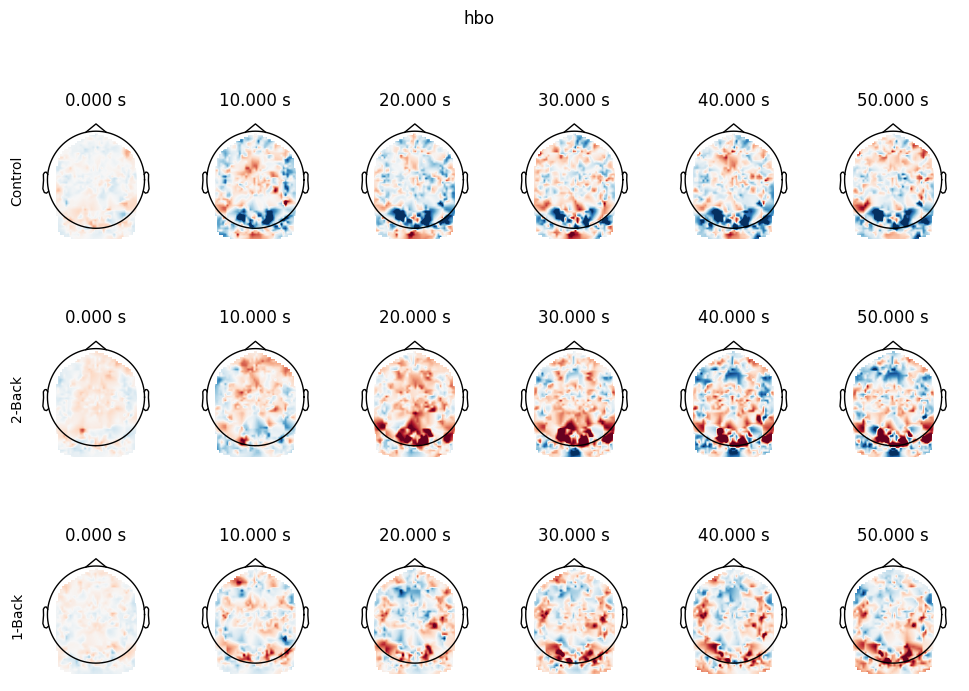

In [87]:
# Create Events
stim_data = extract_stimulus_data(snirf_file)
stim_name = 'StartBlock'
blocks = stim_data[stim_name]
events, _ = mne.events_from_annotations(raw, {stim_name: 1})
condition_columns = [x for x in blocks.columns if stim_name.split('Start')[1] + 'Type' in x]
event_dict = {x.split('.')[1]:i+1 for i,x in enumerate(condition_columns) }
for c in condition_columns:
    events[stim_data[stim_name][c] == 1, 2]  = event_dict[c.split('.')[1]]

# Create MNE Epochs
tmin, tmax = -5, 50
epochs = mne.Epochs(
    raw,
    events,
    event_id=event_dict,
    tmin=tmin,
    tmax=tmax,
    proj=True,
    baseline=(None, 0),
    preload=True,
    detrend=None,
    verbose=True,
)

# Compute Averages for each condition of channels greater than 15mm and less than 30 mm
idx_channels = pick_channels_from_distance_mne_epochs(snirf_file, epochs, min_distance=15, max_distance=30)

condition_evoked = {}
for c in event_dict.keys():
    condition_evoked[f'{c}_evoked'] = epochs[c].average(picks=idx_channels)


# Create stimulus evoked topoplot
chromophore = "hbo"
times = [0, 10, 20, 30, 40, 50]
vlim = (-7, 7)

plot_topo_kwargs = dict(
    ch_type=chromophore,
    sensors=False,
    image_interp="linear",
    vlim=vlim,
    extrapolate="local",
    contours=0,
    colorbar=False,
    show=False,
)

fig, ax = plt.subplots(
    figsize=(12, 8), nrows=3, ncols=len(times), sharex=True, sharey=True
)

for idx_time, time in enumerate(times):
    for i,c in enumerate(condition_evoked.keys()):
        _ = eval(f"condition_evoked[c].plot_topomap([time], axes=ax[{i}][idx_time], **plot_topo_kwargs)")
        if idx_time == 0:
            ax[i][0].set_ylabel(c.split('_')[0])
      
fig.suptitle(chromophore)
plt.savefig(os.path.join(base_dir, 'Figures', metadata['task_name'], f"{metadata['subject']}_{metadata['task_name']}_mne_topoplot.png"), dpi=150)
plt.show()